In [95]:
# Authors: Eric Wang & Xueru Xie

In [40]:
!pip3 install fastfuels==0.5.3  s3fs==0.5.2 fsspec==0.8.3 

In [1]:
import fastfuels
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import rasterio
import rasterio.mask
from shapely import geometry
import geopandas as gpd
from fiona import crs

In [8]:
src=rasterio.open(r'LF2021_FBFM40_210_CONUS/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif')
print(type(src))
print(src.block_shapes)
display(src.files)
print(src.is_tiled)

<class 'rasterio.io.DatasetReader'>
[(128, 128)]


['LF2021_FBFM40_210_CONUS/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif',
 'LF2021_FBFM40_210_CONUS/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif.ovr',
 'LF2021_FBFM40_210_CONUS/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif.aux.xml']

True


In [80]:
#original numbers:
# minx, miny = -122.0003, 45
# maxx, maxy = -122, 45.0003

minx, miny = -121.806464, 38.126339
maxx, maxy = -121.806164, 38.126639

bbox = geometry.box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984

print(geo)

                                            geometry
0  POLYGON ((-121.80616 38.12634, -121.80616 38.1...


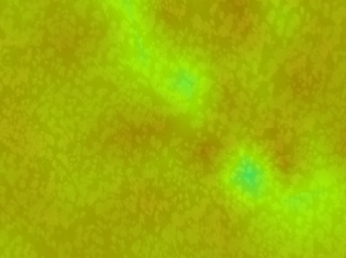
<div align="center">(Forest area with fastfuels sav layered over)<div>

                                            geometry
0  POLYGON ((-2213370.933 1979364.929, -2213361.9...


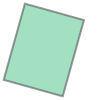

In [81]:
geo_utm=geo.to_crs(crs=src.crs.data)
print(geo_utm)
display(geo_utm.loc[0,"geometry"])

In [82]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords=getFeatures(geo_utm)
display(coords)

[{'type': 'Polygon',
  'coordinates': [[[-2213370.9326172518, 1979364.9285774315],
    [-2213361.9134944724, 1979397.321777114],
    [-2213387.008522878, 1979404.3089388362],
    [-2213396.0277479156, 1979371.9157676257],
    [-2213370.9326172518, 1979364.9285774315]]]}]

In [83]:
out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)

In [84]:
print(np.unique(out_img))

[  102 32767]


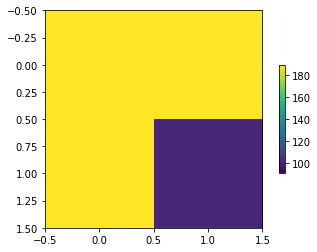

In [85]:
fig,ax=plt.subplots()

h=ax.imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
fig.colorbar(h, shrink=0.5)

Mapped data values align with the fastfuels classification of TL5, High load conifer litter, light slash or dead fuel, spread rate and flame low.

In [46]:
fio = fastfuels.open('https://wifire-data.sdsc.edu:9000/fastfuels/index.fio', ftype='s3', username='fastfuels', password='Treatment##Buffet')
fio.cache_limit = 1e14

In [47]:
print(roi.get_properties())

['bulk_density', 'sav', 'moisture', 'fuel_depth', 'elevation']


Bounding box query found in single source: or_set/or_38.fio


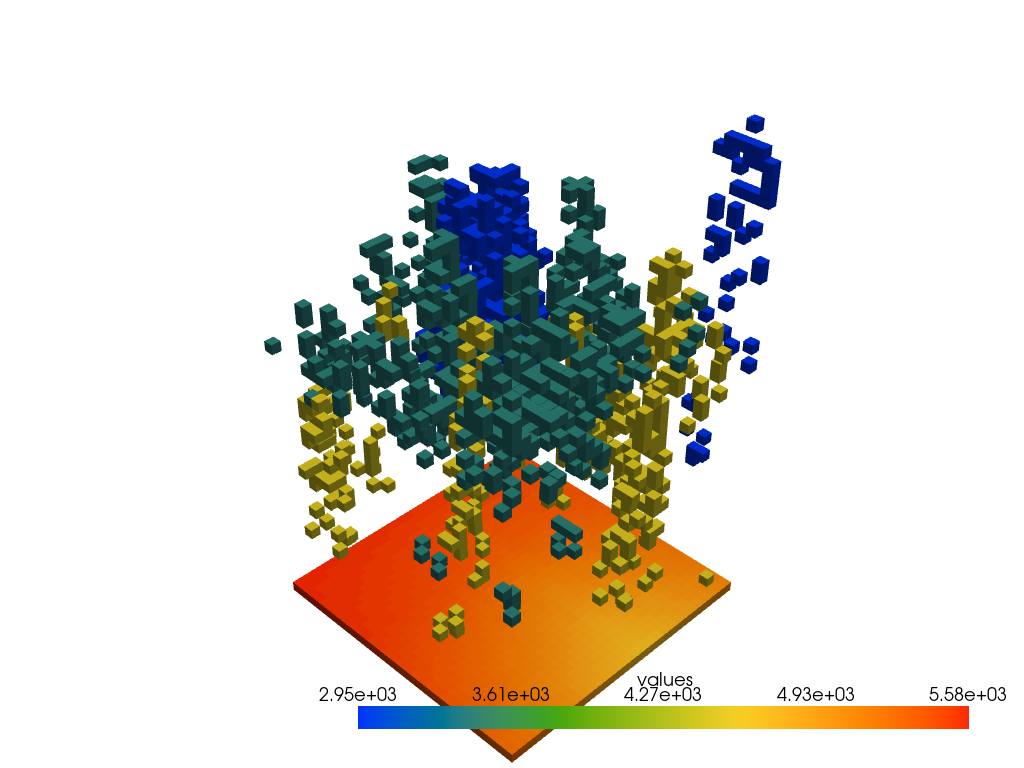

In [53]:
roi = fio.query(-122.0003, 45, 15)
roi.view('sav')

In [54]:
# roi = fio.query(minx, miny, 30)
# roi.view('bulk_density')

In [55]:
raw_sav_data = roi.data_dict['sav']
raw_moisture_data = roi.data_dict['moisture']
raw_elevation_data = roi.data_dict['elevation']

In [56]:
raw_sav_data.shape

(30, 30, 128)

In [63]:
pixels = []
for x in range(len(raw_sav_data)):
    for y in raw_sav_data[x]:
        avg = y.mean()
        pixels.append(avg)

In [65]:
import pandas as pd
df = pd.DataFrame()
df['Pix'] = pixels

<AxesSubplot:>

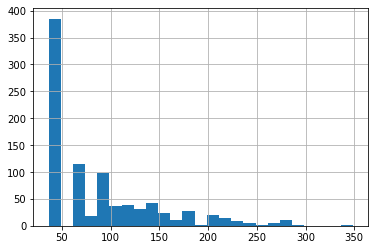

In [69]:
df['Pix'].hist(bins=25)

In [72]:
df[df['Pix']<50].shape[0]/df.shape[0]

0.42777777777777776

In [86]:
#helper function from above
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [93]:
def deez_nuts(lat, long):
    
    output = []

    minx, miny = lat, long
    maxx, maxy = lat + 0.0003, long + 0.0003

    bbox = geometry.box(minx, miny, maxx, maxy)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984
    geo_utm=geo.to_crs(crs=src.crs.data)
    coords=getFeatures(geo_utm)
    out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)
    
    output.append(np.unique(out_img)[0])
    fig,ax=plt.subplots(1,2)

    h=ax[0].imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
    fig.colorbar(h, shrink=0.5)
    
    roi = fio.query(lat, long, 15)
    print(roi.view('sav'))
    raw_sav_data = roi.data_dict['sav']
    
    pixels = []
    for x in range(len(raw_sav_data)):
        for y in raw_sav_data[x]:
            avg = y.mean()
            pixels.append(avg)
            
    df = pd.DataFrame()
    df['Pix'] = pixels
    print(df['Pix'].hist(bins=25))
    
    output.append(df[df['Pix']<50].shape[0]/df.shape[0] * 100)
    
    print('The label for this region is ' + str(output[0]))
    print('The percentage of flat surface in this region is ' + str(output[1]))
    return output

C:\Users\ericw\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


Bounding box query found in single source: ca.fio


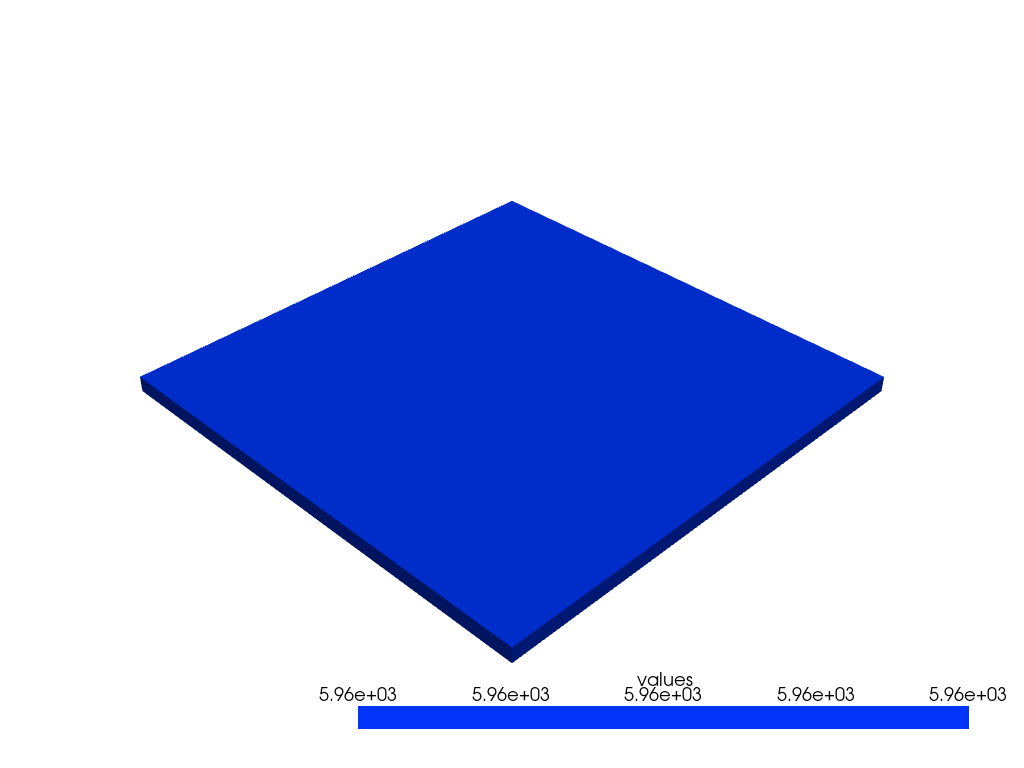

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 102
The percentage of flat surface in this region is 100.0


[102, 100.0]

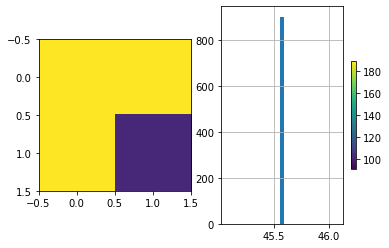

In [94]:
deez_nuts(  -121.806464, 38.126339)